In [2]:
import os
os.chdir('./..')

# from src.train_LSTM import *
# from src.test_torch_cnn import *
from src.train_LSTM_Att import *

import shap
import matplotlib.pyplot as plt
import seaborn as sns

torch.backends.cudnn.enabled=False

# LSTM

In [24]:
root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

n_layer = 2
n_hidden = 64
n_hidden_dense = 32
resample_rate = None
imputation = 'mean'

config_lstm = {
    "n_input_static": 4,
    "n_input_seq": 25,
    "n_classes": 1,
    "n_hidden": n_hidden,
    "n_layers": n_layer,
    "hidden_dense": n_hidden_dense,
    "lr": 1e-3,
    "batch_size": 64,
    "dropout": 0.75,
    "dropout_dense": 0.5,
    'resample_rate': resample_rate,
    'imputation': imputation,
}

model_lstm = FullNet.load_from_checkpoint(checkpoint_path='models/LSTM_torch/2layer/version_0/pred0-impmean-sampling5-epoch55-val_roc0.90.ckpt', 
                                          config=config_lstm, data_folder=data_folder)


trainer = Trainer(gpus=1)
trainer.test(model_lstm);

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8092400431632996,
 'test_f1': 0.650146484375,
 'test_loss': 0.4157116711139679,
 'test_precision': 0.5459185838699341,
 'test_recall': 0.8233897089958191,
 'test_roc': 0.8954294919967651}
--------------------------------------------------------------------------------


In [25]:
model_lstm.to(device='cuda')

# X, _, y, _ = train_test_split(X_test, y_test, train_size=.02, random_state=0, shuffle=True, stratify=y_test)

ds_shap = PatientDataset(data_folder, X, y)
loader_shap = DataLoader(ds_shap, batch_size=32)

loader_shap = DataLoader(ds_shap, batch_size=ds_shap.__len__())
data = next(iter(loader_shap))

for d in data['data']:
    data['data'][d] = data['data'][d].to(device='cuda')
y = data['label'].to(device='cuda')

# model.train()
e = shap.DeepExplainer(
    model_lstm,
    [data['data']['static'], data['data']['time_series']],
)

shap_values_lstm = e.shap_values(
    [data['data']['static'], data['data']['time_series']]
)
sv = np.empty(len(shap_values_lstm_att),dtype=object)
sv[:] = shap_values_lstm_att
np.save(f'models/LSTMATT_torch/2layer/version_0/pred{pred}-imp{imputation}-sampling5-epoch94-val_roc0.90_shap.npy',
       sv)

feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                            sep=';', header=0, index_col=[0,1]).columns.to_numpy()

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_lstm[1].mean(axis=1)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [3]:
pred = 6
imputation = 'mean'
resample_rate = None

n_layer = 2
n_hidden = 64
n_hidden_dense = 32

config_lstm = {
    "n_input_static": 4,
    "n_input_seq": 33,
    "n_classes": 1,
    "n_hidden": n_hidden,
    "n_layers": n_layer,
    "hidden_dense": n_hidden_dense,
    "lr": 1e-3,
    "batch_size": 64,
    "dropout": 0.75,
    "dropout_dense": 0.5,
    'resample_rate': resample_rate,
    'imputation': imputation,
}

root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/_dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/_dx_pred_{pred}_12_3src/ts_aligned')
data_split = np.load(os.path.join(root_folder, 'data_split.npy'), allow_pickle=True).item()

model_lstm = LSTM_CLF.load_from_checkpoint(checkpoint_path='models/LSTM_torch/2layer/version_5/pred12-impmean-samplingNone-epoch00-val_roc0.98.ckpt', 
                                          config=config_lstm, data_folder=data_folder, data_split=data_split)


trainer = Trainer(gpus=1)
trainer.test(model_lstm);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8225343823432922,
 'test_f1': 0.6169238686561584,
 'test_loss': 0.45185476541519165,
 'test_precision': 0.5113685727119446,
 'test_recall': 0.8032140135765076,
 'test_roc': 0.8547483086585999}
--------------------------------------------------------------------------------


In [6]:
model_lstm.to(device='cuda')

X, _, y, _ = train_test_split(data_split['X_test'], y_test, train_size=.02, random_state=0, shuffle=True, stratify=y_test)

ds_shap = PatientDataset(data_folder, X, y)
loader_shap = DataLoader(ds_shap, batch_size=32)

loader_shap = DataLoader(ds_shap, batch_size=ds_shap.__len__())
data = next(iter(loader_shap))

for d in data['data']:
    data['data'][d] = data['data'][d].to(device='cuda')
y = data['label'].to(device='cuda')

# model.train()
e = shap.DeepExplainer(
    model_lstm,
    [data['data']['static'], data['data']['time_series']],
)

shap_values_lstm = e.shap_values(
    [data['data']['static'], data['data']['time_series']]
)
sv = np.empty(len(shap_values_lstm_att),dtype=object)
sv[:] = shap_values_lstm_att
np.save(f'models/LSTMATT_torch/2layer/version_0/pred{pred}-imp{imputation}-sampling5-epoch94-val_roc0.90_shap.npy',
       sv)

feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                            sep=';', header=0, index_col=[0,1]).columns.to_numpy()

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_lstm[1].mean(axis=1)

NameError: name 'X' is not defined

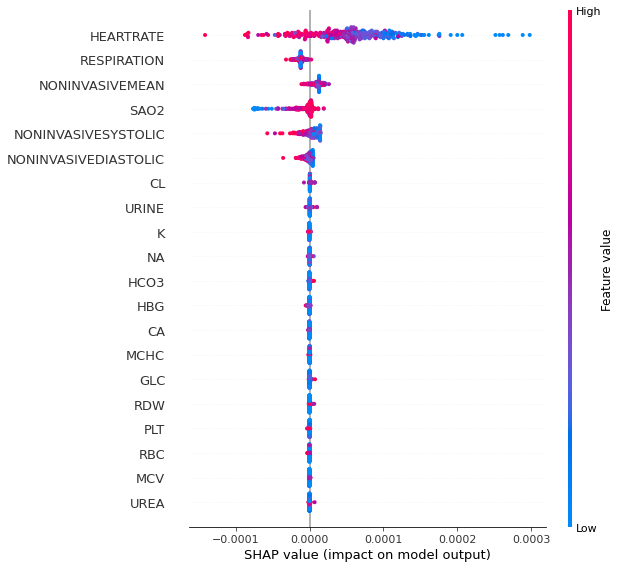

In [27]:
shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names),)

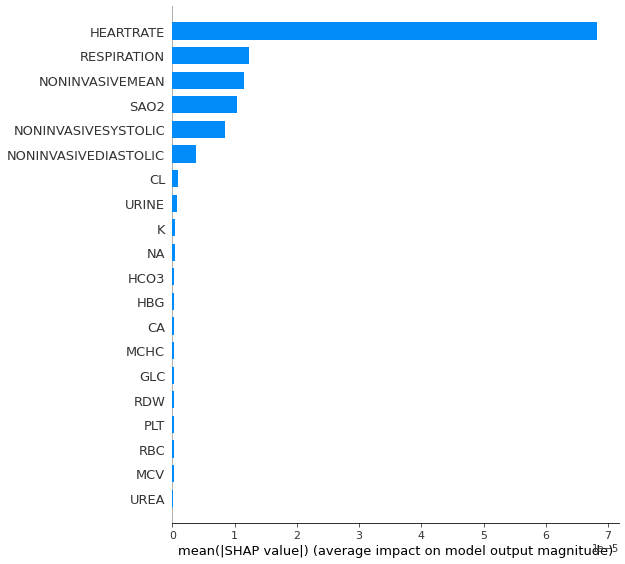

In [26]:
shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names), plot_type='bar')

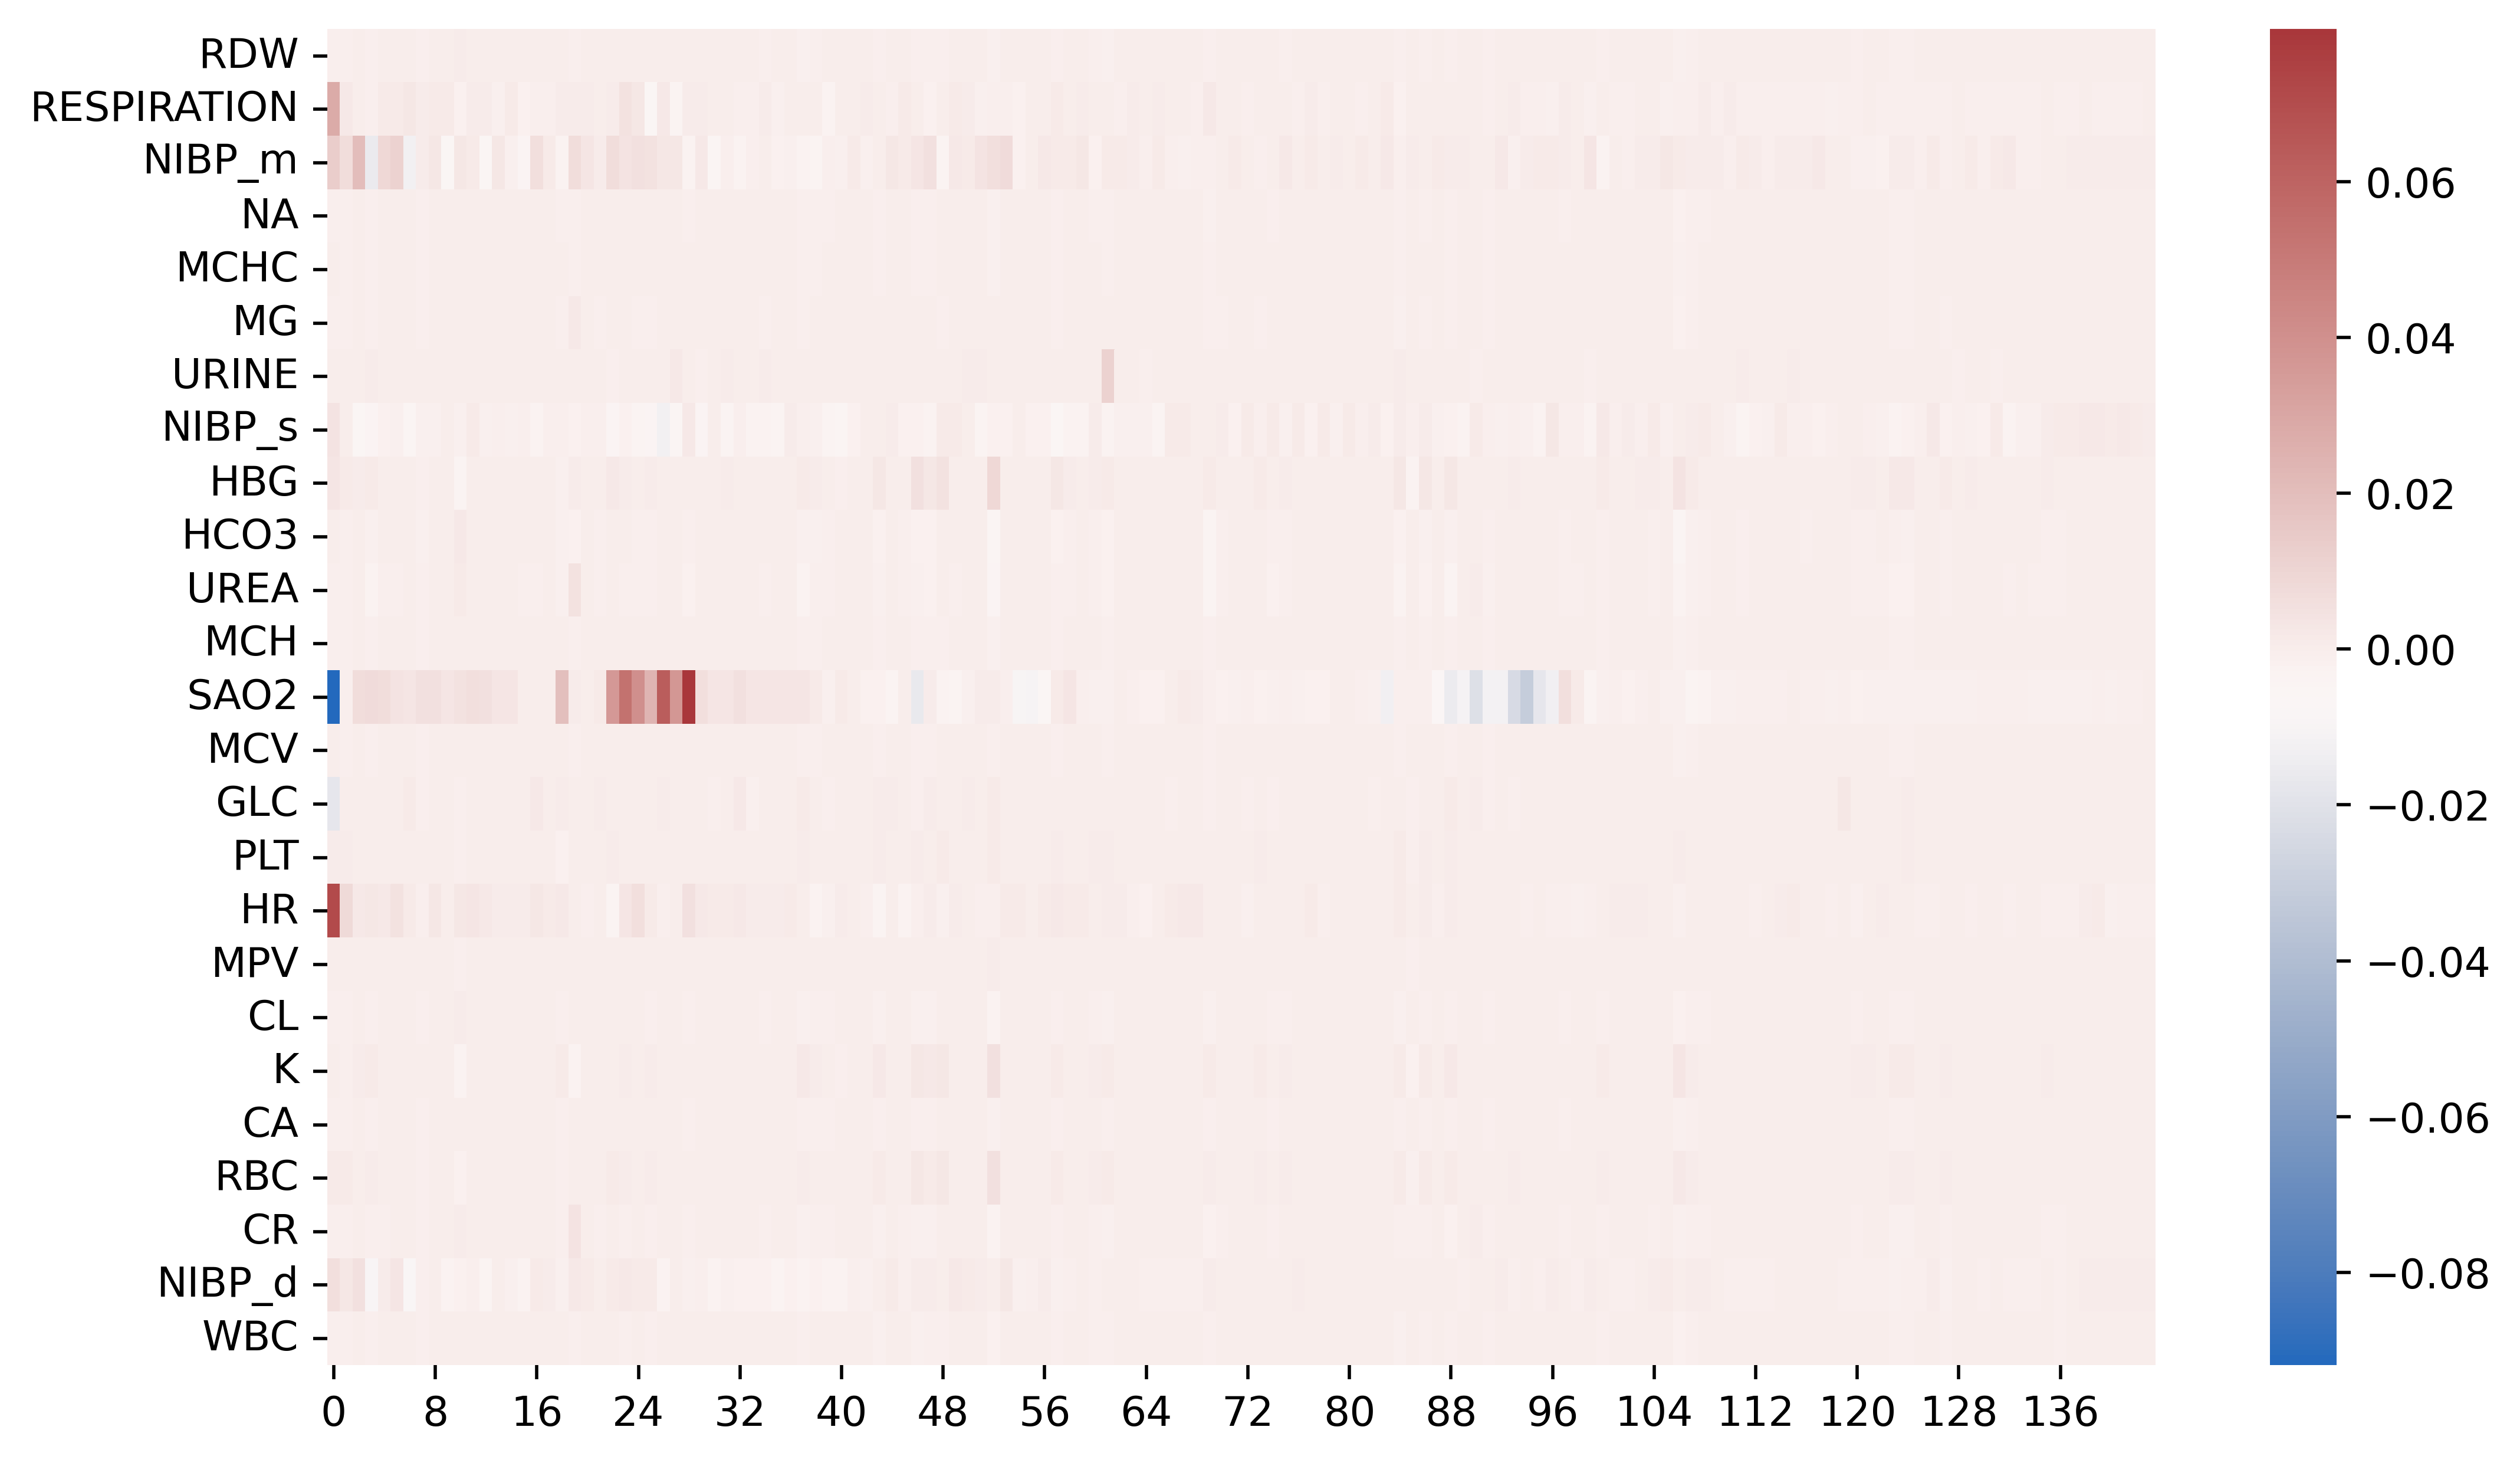

In [54]:
# xlabels = [f'{xlabel*5/60:.1f}' for xlabel in np.arange(0, 144)]
xlabels = [f'{xlabel}' for xlabel in np.arange(0, 144)]
feat_scores = shap_values_lstm[1][1,:,:].T
fig, ax = plt.subplots(figsize=(10,6), dpi=500)
ax = sns.heatmap(feat_scores, yticklabels=feature_names, xticklabels=xlabels,
                cmap='vlag')
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",rotation_mode="anchor");
plt.locator_params(axis='x', nbins=18)
plt.show()

# LSTM + Attention

In [2]:
from src.test_torch_lstm_att import LSTM_ATT

pred = 0
root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

n_layer = 2
n_hidden = 64
n_hidden_dense = 32
resample_rate = None
imputation = 'mean'

config_lstm_att = {
    "n_input_static": 4,
    "n_input_seq": 25,
    "n_classes": 1,
    "n_hidden": n_hidden,
    "n_layers": n_layer,
    "hidden_dense": n_hidden_dense,
    "lr": 1e-3,
    "batch_size": 64,
    "dropout": 0.75,
    "dropout_dense": 0.5,
    'resample_rate': resample_rate,
    'imputation': imputation,
}


model_file = f'models/LSTMATT_torch/2layer/version_0/pred{pred}-imp{imputation}-sampling5-epoch94-val_roc0.90.ckpt'
model_lstm_att = LSTM_ATT.load_from_checkpoint(checkpoint_path=model_file, 
                                               config=config_lstm_att, data_folder=data_folder)

trainer = Trainer(gpus=1)
trainer.test(model_lstm_att);

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8060852289199829,
 'test_f1': 0.6414980888366699,
 'test_loss': 0.44059818983078003,
 'test_precision': 0.541405200958252,
 'test_recall': 0.8081993460655212,
 'test_roc': 0.8920626044273376}
--------------------------------------------------------------------------------


In [20]:
model_lstm_att.to(device='cuda')

X, _, y, _ = train_test_split(X_test, y_test, train_size=.02, random_state=0, shuffle=True, stratify=y_test)

ds_shap = PatientDataset(data_folder, X, y)
loader_shap = DataLoader(ds_shap, batch_size=32)

loader_shap = DataLoader(ds_shap, batch_size=ds_shap.__len__())
data = next(iter(loader_shap))

for d in data['data']:
    data['data'][d] = data['data'][d].to(device='cuda')
y = data['label'].to(device='cuda')

# model.train()
e = shap.DeepExplainer(
    model_lstm_att,
    [data['data']['static'], data['data']['time_series']],
)

shap_values_lstm_att = e.shap_values(
    [data['data']['static'], data['data']['time_series']]
)

sv = np.empty(len(shap_values_lstm_att),dtype=object)
sv[:] = shap_values_lstm_att
np.save(f'models/LSTMATT_torch/2layer/version_0/pred{pred}-imp{imputation}-sampling5-epoch94-val_roc0.90_shap.npy',
       sv)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


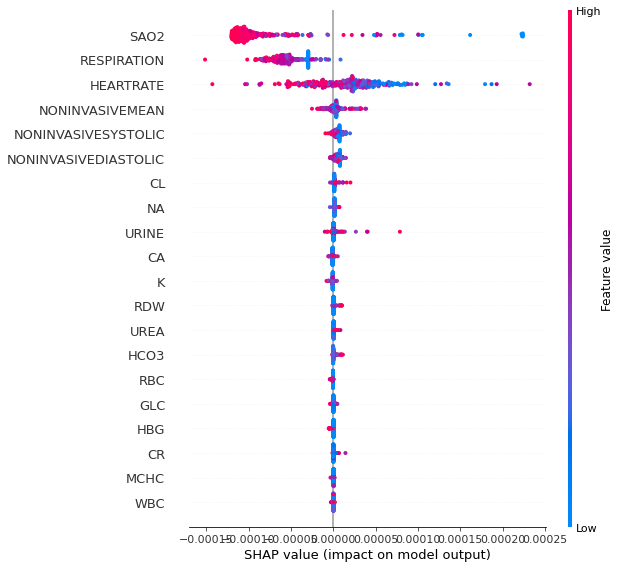

In [22]:
feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                            sep=';', header=0, index_col=[0,1]).columns.to_numpy()

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_lstm_att[1].mean(axis=1)

shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names))

In [3]:
from src.test_torch_lstm_att import LSTM_ATT

pred = 0
root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

n_layer = 2
n_hidden = 64
n_hidden_dense = 32
resample_rate = None
imputation = 'mean'

config_lstm_att = {
    "n_input_static": 4,
    "n_input_seq": 25,
    "n_classes": 1,
    "n_hidden": n_hidden,
    "n_layers": n_layer,
    "hidden_dense": n_hidden_dense,
    "lr": 1e-3,
    "batch_size": 64,
    "dropout": 0.75,
    "dropout_dense": 0.5,
    'resample_rate': resample_rate,
    'imputation': imputation,
}

model_file = f'models/LSTMATT_torch/2layer/version_1/pred{pred}-imp{imputation}-sampling5-epoch62-val_roc0.85.ckpt'
model_lstm_att = LSTM_ATT.load_from_checkpoint(checkpoint_path=model_file, 
                                               config=config_lstm_att, data_folder=data_folder)

trainer = Trainer(gpus=1)
trainer.test(model_lstm_att);

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7767106294631958,
 'test_f1': 0.5947982668876648,
 'test_loss': 0.5074324607849121,
 'test_precision': 0.49872899055480957,
 'test_recall': 0.7603543400764465,
 'test_roc': 0.8481214046478271}
--------------------------------------------------------------------------------


In [4]:
model_lstm_att.to(device='cuda')

X, _, y, _ = train_test_split(X_test, y_test, train_size=.02, random_state=0, shuffle=True, stratify=y_test)

ds_shap = PatientDataset(data_folder, X, y)
loader_shap = DataLoader(ds_shap, batch_size=32)

loader_shap = DataLoader(ds_shap, batch_size=ds_shap.__len__())
data = next(iter(loader_shap))

for d in data['data']:
    data['data'][d] = data['data'][d].to(device='cuda')
y = data['label'].to(device='cuda')

# model.train()
e = shap.DeepExplainer(
    model_lstm_att,
    [data['data']['static'], data['data']['time_series']],
)

shap_values_lstm_att = e.shap_values(
    [data['data']['static'], data['data']['time_series']]
)

sv = np.empty(len(shap_values_lstm_att),dtype=object)
sv[:] = shap_values_lstm_att
np.save(f'models/LSTMATT_torch/2layer/version_0/pred{pred}-imp{imputation}-sampling5-epoch62-val_roc0.85_shap.npy',
       sv)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


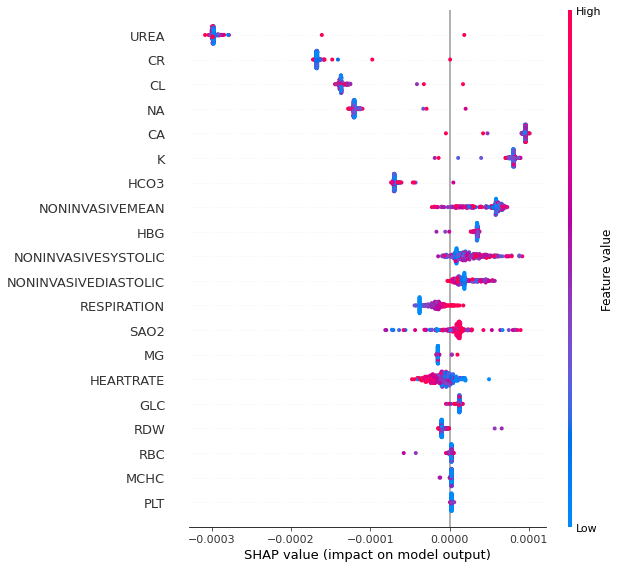

In [5]:
feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                            sep=';', header=0, index_col=[0,1]).columns.to_numpy()

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_lstm_att[1].mean(axis=1)

shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names))

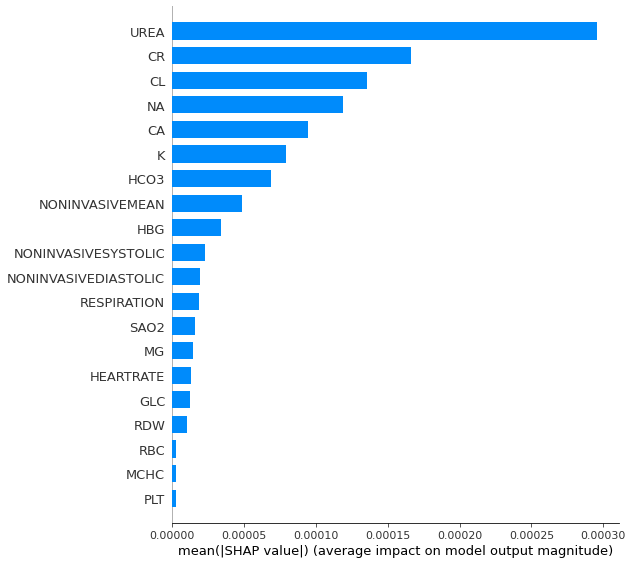

In [6]:
feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                            sep=';', header=0, index_col=[0,1]).columns.to_numpy()

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_lstm_att[1].mean(axis=1)

shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names), plot_type='bar')

In [9]:
pred = 0
root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')
data_split = np.load(os.path.join(root_folder, 'data_split.npy'), allow_pickle=True).item()

n_layer = 2
n_hidden = 64
n_hidden_dense = 32
resample_rate = None
imputation = 'mean'


config_lstm_att = {
    "n_input_static": 4,
    "n_input_seq": 33,
    "n_classes": 1,
    "n_hidden": n_hidden,
    "n_layers": n_layer,
    "hidden_dense": n_hidden_dense,
    "lr": 1e-3,
    "batch_size": 64,
    "dropout": 0,
    "dropout_dense": 0.5,
    'resample_rate': resample_rate,
    'imputation': imputation,
}

model_file = f'models/LSTMATT_torch/test_lstmatt_0_mean_5.ckpt'
model_lstm_att = LSTM_ATT.load_from_checkpoint(checkpoint_path=model_file, 
                                               config=config_lstm_att, data_folder=data_folder, data_split=data_split)

# trainer = Trainer(gpus=1)
# trainer.test(model_lstm_att);

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# X_train = data_split['X_train']
# y_train = data_split['y_train']
# X_val = data_split['X_val']
# y_val = data_split['y_val']
X_test = data_split['X_test']
y_test = data_split['y_test']

model_lstm_att.to(device='cpu')

X, _, y, _ = train_test_split(X_test, y_test, train_size=.02, random_state=0, shuffle=True, stratify=y_test)

ds_shap = PatientDataset(data_folder, X, y)
loader_shap = DataLoader(ds_shap, batch_size=ds_shap.__len__())
data = next(iter(loader_shap))

for d in data['data']:
    data['data'][d] = data['data'][d].to(device='cpu')
y = data['label'].to(device='cpu')

# model.train()
e = shap.DeepExplainer(
    model_lstm_att,
    [data['data']['static'], data['data']['time_series']],
)

shap_values_lstm_att = e.shap_values(
    [data['data']['static'], data['data']['time_series']]
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


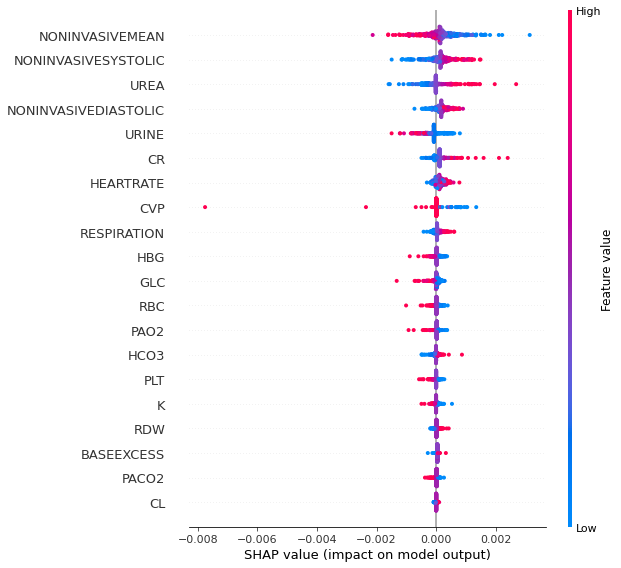

In [12]:
feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                            sep=';', header=0, index_col=[0,1]).columns.to_numpy()

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_lstm_att[1].mean(axis=1)

shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names))

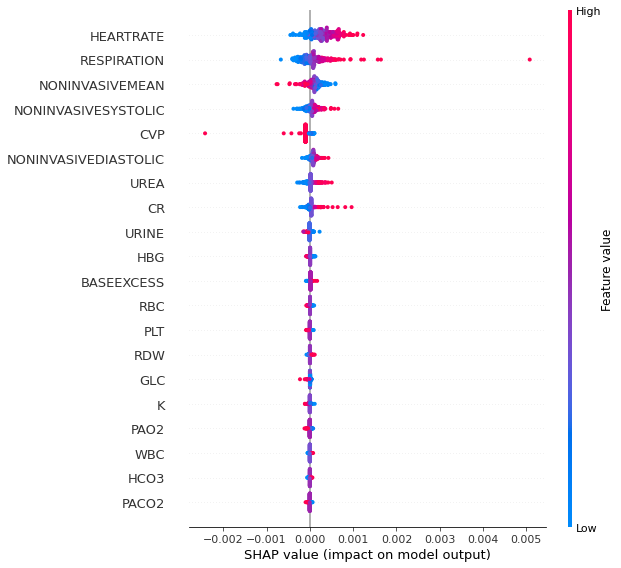

In [8]:
feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                            sep=';', header=0, index_col=[0,1]).columns.to_numpy()

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_lstm_att[1].mean(axis=1)

shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names))

# CNN

In [9]:
n_input_static = 4
n_input_seq = 25
n_filters_per_channel = 3

config_cnn = {
        "n_input_static": n_input_static,
        "n_input_seq": n_input_seq,
        "n_classes": 1,
        "cnn_kernel_size": 8,
        "cnn_stride": 4,
        "n_group_cnn": n_input_seq,
        "n_hidden": n_filters_per_channel*n_input_seq,
        "pool_kernel_size": 8,
        "dropout_dense": 0.5,
        "lr": 1e-3,
        "batch_size": 64,
    }
model_cnn = CNN_CLF.load_from_checkpoint(checkpoint_path='models/Conv1D_torch/epoch75-val_roc0.87.ckpt', 
                                     config=config_cnn, data_folder=data_folder)


trainer = Trainer(gpus=1)
trainer.test(model_cnn);

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7646522521972656,
 'test_f1': 0.5994585752487183,
 'test_loss': 0.4742410182952881,
 'test_precision': 0.4832017123699188,
 'test_recall': 0.8136575818061829,
 'test_roc': 0.867400586605072}
--------------------------------------------------------------------------------


In [10]:
model_cnn.to(device='cpu')

X, _, y, _ = train_test_split(X_test, y_test, train_size=.02, random_state=0, shuffle=True, stratify=y_test)

ds_shap = PatientDataset(data_folder, X, y)
loader_shap = DataLoader(ds_shap, batch_size=32)

loader_shap = DataLoader(ds_shap, batch_size=ds_shap.__len__())
data = next(iter(loader_shap))

for d in data['data']:
    data['data'][d] = data['data'][d].to(device='cpu')
y = data['label'].to(device='cpu')

# model.train()
e = shap.DeepExplainer(
    model_cnn,
    [data['data']['static'], data['data']['time_series']],
)

shap_values_cnn = e.shap_values(
    [data['data']['static'], data['data']['time_series']]
)

feature_names = [
    'RDW', 'RESPIRATION', 'NIBP_m', 'NA', 'MCHC', 'MG', 'URINE',
    'NIBP_s', 'HBG', 'HCO3', 'UREA', 'MCH', 'SAO2', 'MCV', 'GLC',
    'PLT', 'HR', 'MPV', 'CL', 'K', 'CA', 'RBC', 'CR', 'NIBP_d', 'WBC'
]

data_ts = data['data']['time_series']
data_mask = data_ts!=0
data_mask_ = data_mask.sum(dim=1) == 0
mask_sum = data_mask.sum(dim=1)
mask_sum[data_mask_] = 1
data_ts_mean = (data_ts * data_mask).sum(dim=1) / mask_sum

shap_ts_mean = shap_values_cnn[1].mean(axis=1)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


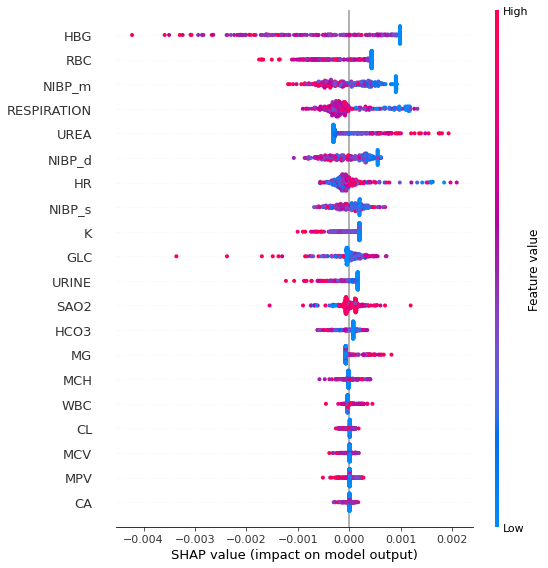

In [12]:
shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names),)

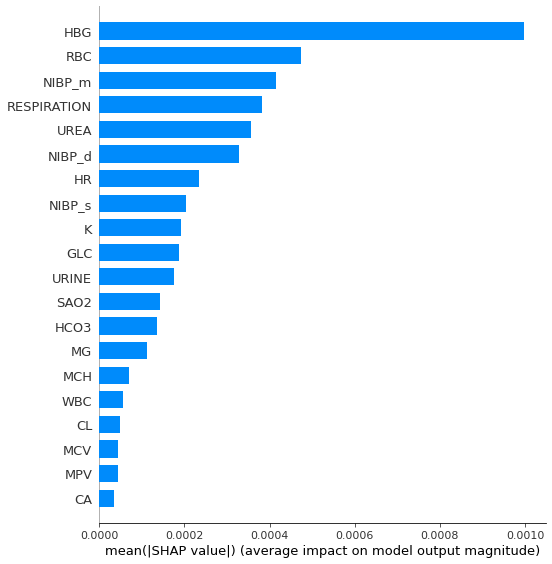

In [13]:
shap.summary_plot(shap_ts_mean, features=data_ts_mean.cpu().detach().numpy(), 
                  feature_names=np.array(feature_names), plot_type='bar')

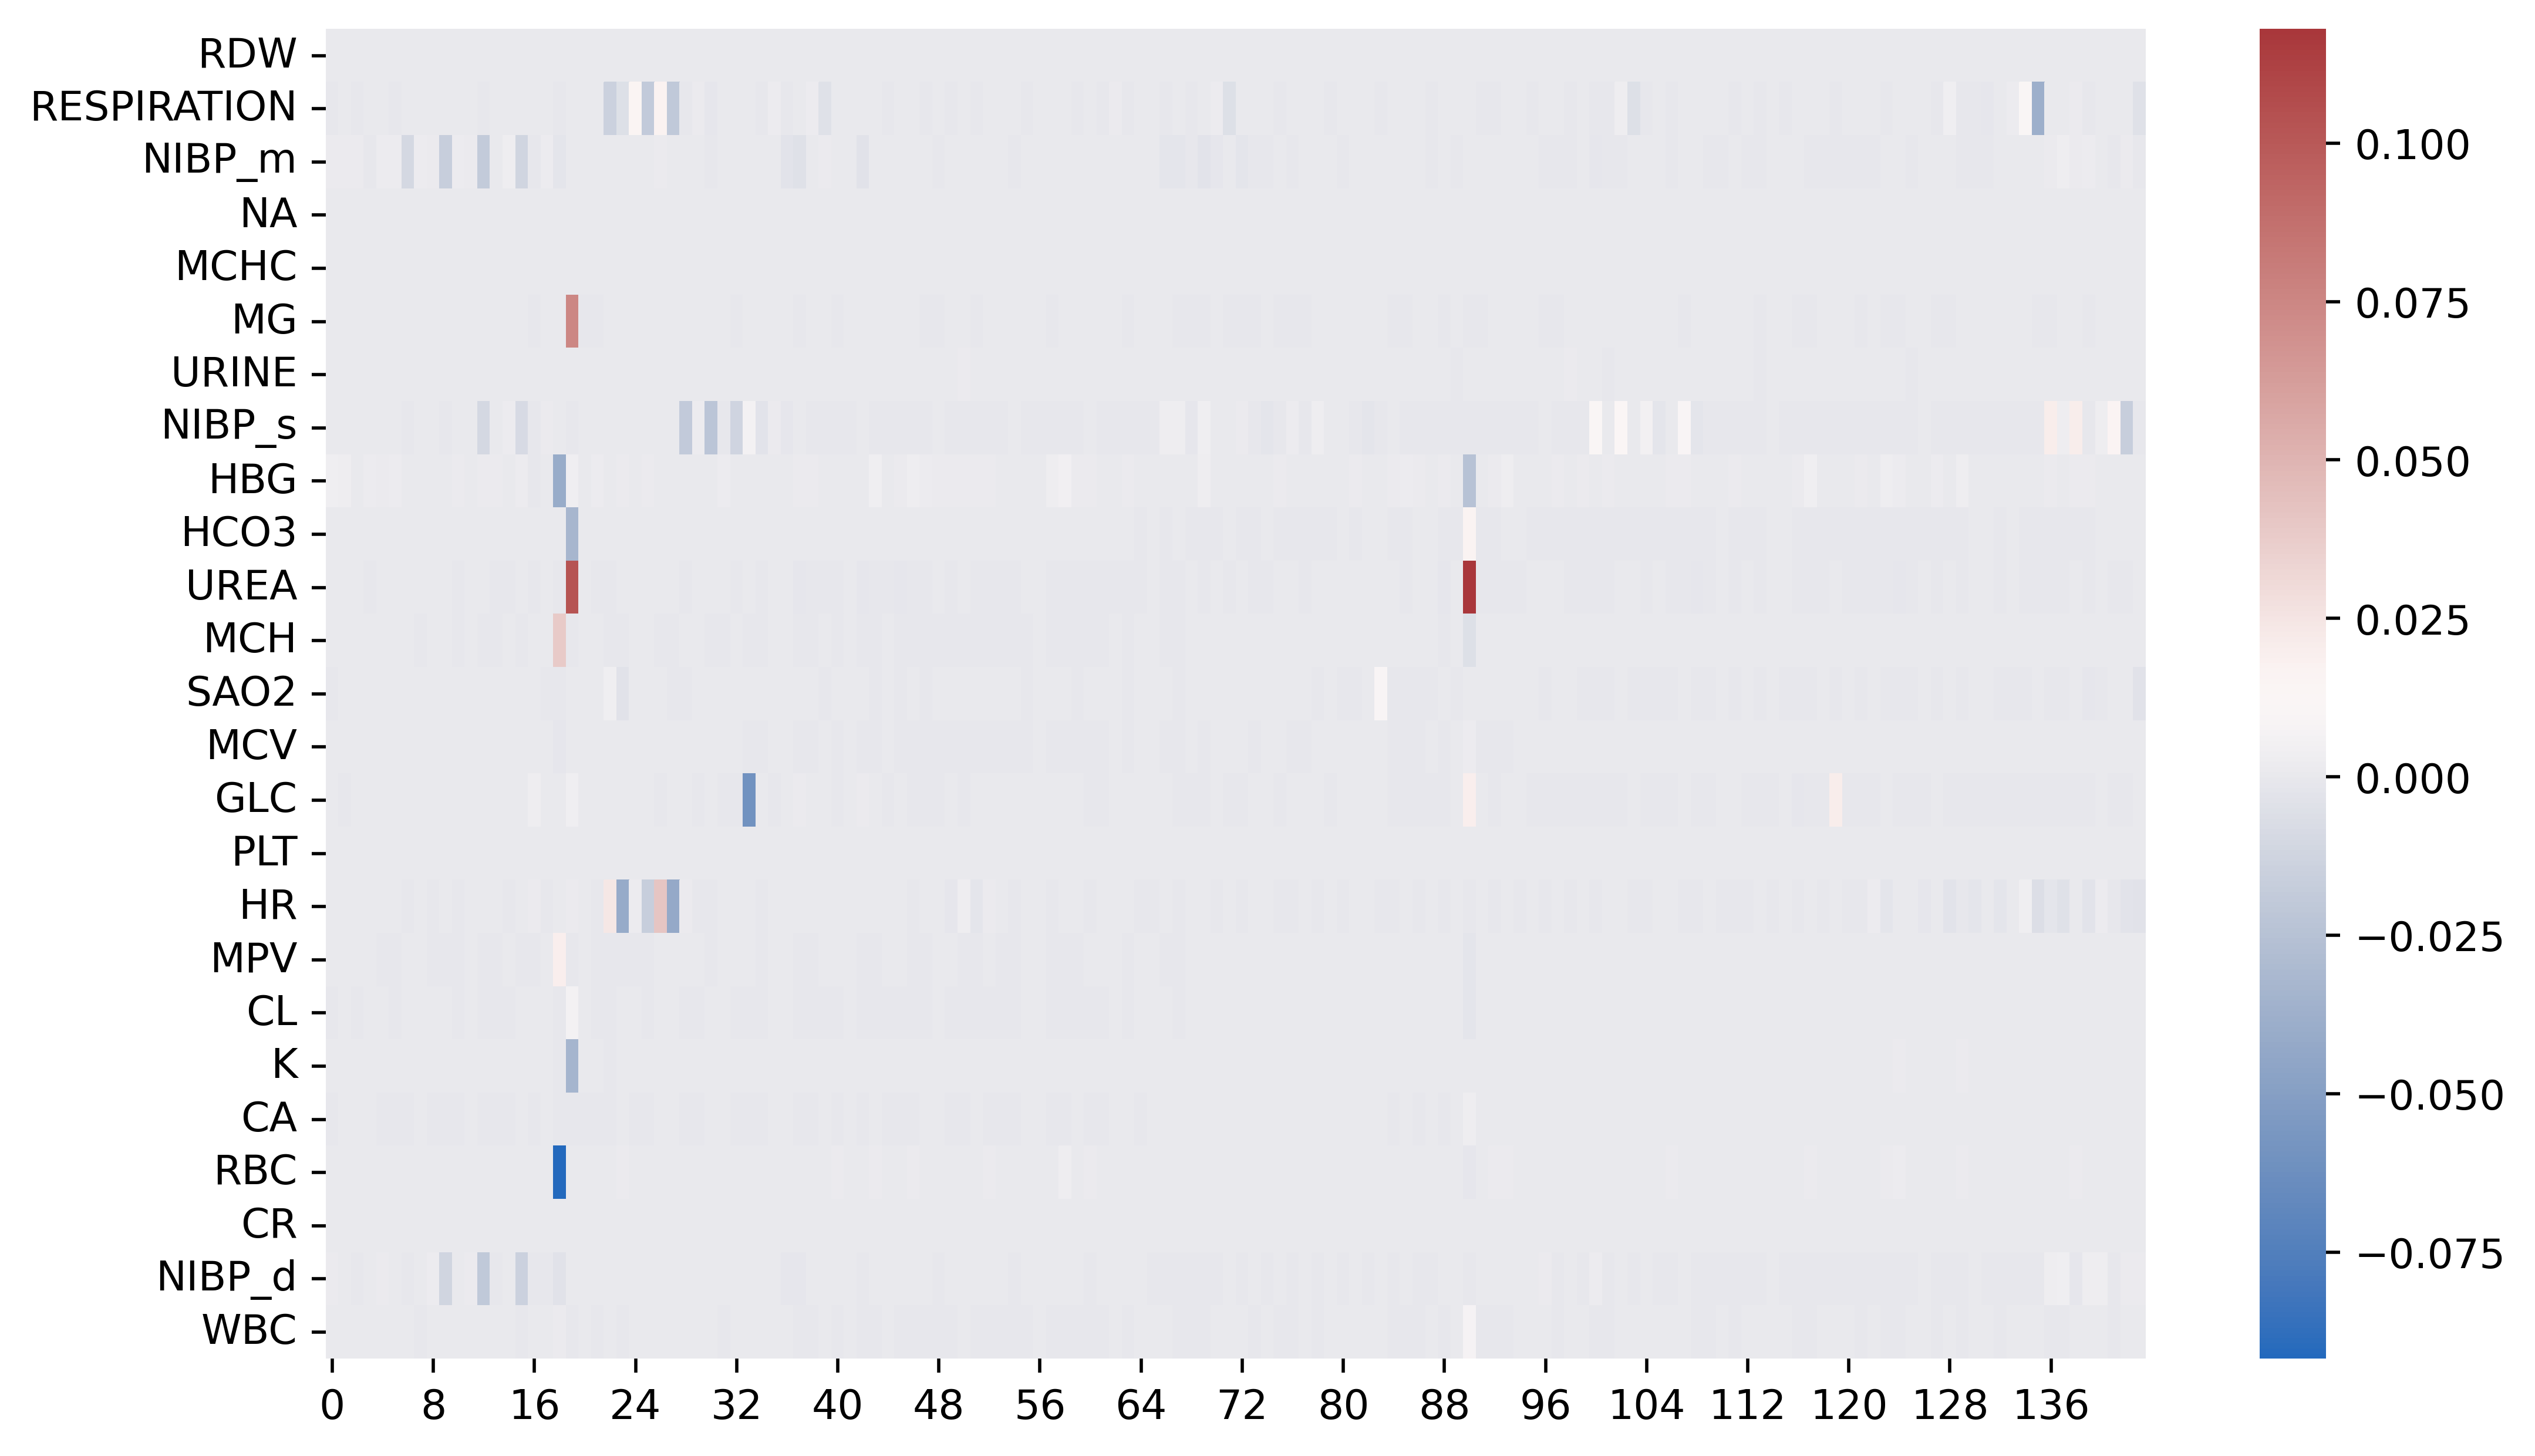

In [53]:
# xlabels = [f'{xlabel*5/60:.1f}' for xlabel in np.arange(0, 144)]
xlabels = [f'{xlabel}' for xlabel in np.arange(0, 144)]
feat_scores = shap_values_cnn[1][1,:,:].T
fig, ax = plt.subplots(figsize=(10,6), dpi=500)
ax = sns.heatmap(feat_scores, yticklabels=feature_names, xticklabels=xlabels,
                cmap='vlag')
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",rotation_mode="anchor");
plt.locator_params(axis='x', nbins=18)
plt.show()

In [17]:
np.where(np.array(y)==1)

(array([  1,   5,   8,  11,  12,  13,  17,  18,  21,  26,  28,  32,  35,
         38,  40,  50,  51,  54,  59,  61,  64,  69,  74,  78,  86,  88,
         91, 107, 108, 116, 117, 132, 135, 146, 152, 153, 162, 165, 166,
        170, 179, 180, 187, 189, 194, 195, 196, 198, 205, 211, 215, 227,
        237, 243, 245, 246, 249, 256, 260, 261, 269, 276, 284]),)

In [35]:
model_lstm.eval()
model_lstm.to(device='cpu')
y_lstm = model_lstm(data['data']['static'], data['data']['time_series'])

In [36]:
model_cnn.eval()
y_cnn = model_cnn(data['data']['static'], data['data']['time_series'])

In [52]:
idx = 1
y_lstm[idx],y_cnn[idx]

(tensor([0.9767], grad_fn=<SelectBackward0>),
 tensor([0.7122], grad_fn=<SelectBackward0>))

In [1]:
import os
os.chdir('./..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings("ignore")

import shap

In [2]:
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def preprocess(X, y, imputation='mean'):
    nor = StandardScaler().fit(X)

    if imputation == 'mean':
        imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X)
        X = imp.transform(X)
    elif imputation == 'zero':
        imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit(X)
        X = imp.transform(X)

    X = nor.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True, stratify=y)

    return X_train, X_test, y_train, y_test


for pred in [0, 6, 12]:
    np.random.seed(0)

    data_pos = np.load(f'processed/patient_data/dx_pred_{pred}_12_3src/data_positive.npy')
    data_neg = np.load(f'processed/patient_data/dx_pred_{pred}_12_3src/data_negative.npy')
    X_raw = np.vstack((data_pos, data_neg))
    y_raw = [1] * len(data_pos) + [0] * len(data_neg)
    X_train, X_test, y_train, y_test = preprocess(X_raw, y_raw)

    save_model_path = f'models/RF/pred{pred}-impmean-processed.sav'
    clf = pickle.load(open(save_model_path, 'rb'))
    
    y_pred = clf.predict(X_test)

    METRICS = {
        'acc': accuracy_score,
        'recall': recall_score,
        'precision': precision_score,
        'f1': f1_score,
        'auroc': roc_auc_score
    }

    for metric in METRICS:
        print(f'PRED {pred} - {metric}: {METRICS[metric](y_test, y_pred)}')

PRED 0 - acc: 0.847210541070928
PRED 0 - recall: 0.4182220816197406
PRED 0 - precision: 0.7949488875526157
PRED 0 - f1: 0.5480928689883914
PRED 0 - auroc: 0.6937603610583623
PRED 6 - acc: 0.8672891699139769
PRED 6 - recall: 0.35525260625501204
PRED 6 - precision: 0.8180978762696214
PRED 6 - f1: 0.4953871959742801
PRED 6 - auroc: 0.6687580218634384
PRED 12 - acc: 0.9007847533632287
PRED 12 - recall: 0.13830557566980448
PRED 12 - precision: 0.7958333333333333
PRED 12 - f1: 0.2356570018507094
PRED 12 - auroc: 0.566946971682926
